In [2]:
import numpy as np
import pandas as pd

class InvalidTypeError(Exception):
    """enter either a call or put option for the type param"""
    pass

TODO: 
- make a portfolio with weights
- run monte carlo simulation


Step 1 / INTRO: Get baseline monte carlo simulation with constant volatility (we use today's volatility for all steps in the MC simulation)

XJ2WQUNNHBYG6D9S
Saved to: treasury_data/3_month_treasury_constant_maturity_yield.csv
Saved to: treasury_data/2_year_treasury_constant_maturity_yield.csv
Saved to: treasury_data/10_year_treasury_constant_maturity_yield.csv
r=0.03575316970581784
AAPL
start date = 2025-07-02 00:00:00
S0 = 212.44
sigma (annualized) = 0.4009447559871884
dividend yield = 0.002596625847265914


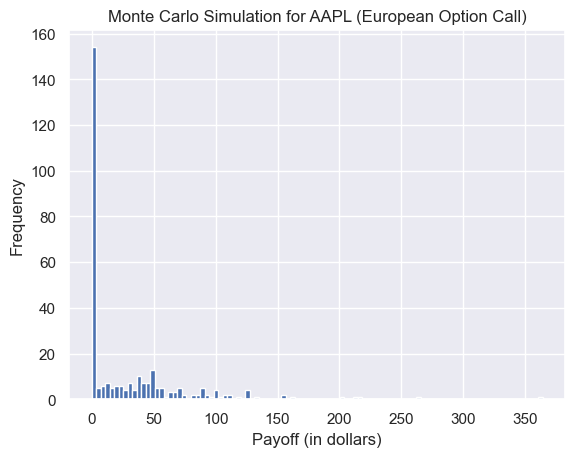

MC_estimator=28.153030449539436, SE=2.62746853964558


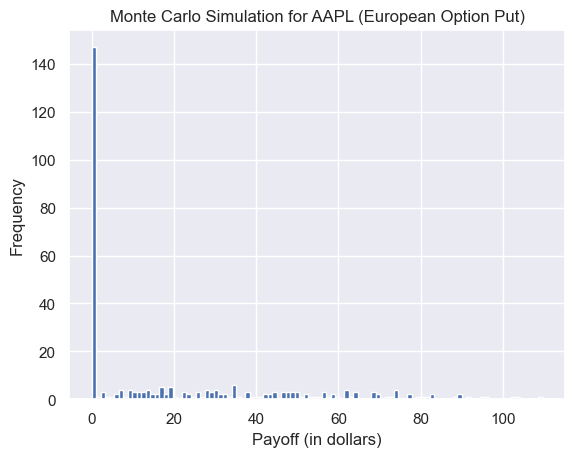

MC_estimator=19.92202160605733, SE=1.5404746434029915
217.22958278398661


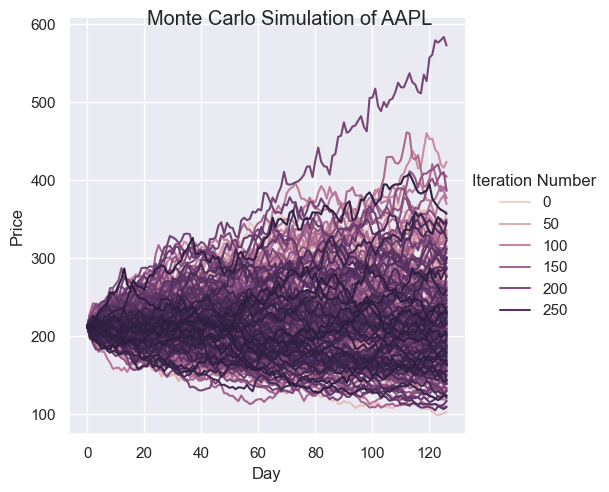

In [37]:
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from src.api_keys import ALPHAVANTAGE_API_KEY # type: ignore


NUM_MINS = '1'
print(ALPHAVANTAGE_API_KEY)

################################################################################
#                           DOWNLOAD FUNCTION                                    
################################################################################
def download_once(url: str, local_path: str, repull=False) -> Path:
    p = Path(local_path)
    if p.exists() and not repull: # do not rewrite path
        return p
    r = requests.get(url, timeout=30) # sends http get request to url. stores it to a response object
    r.raise_for_status() # checks if response object's status is 200-299 (not 404 for example)
    p.write_bytes(r.content) 
    return p

def get_stooq_daily(
    ticker: str,
    data_dir: str = "stock_data",
    repull: bool = False
) -> pd.DataFrame:
    """
    Download (once) and load daily OHLCV data from Stooq.
    """
    ticker_lower = ticker.lower().strip()
    url = f"https://stooq.com/q/d/l/?s={ticker_lower}.us&i=d"
    local_path = f"{data_dir}/{ticker}_stooq_daily.csv"
    csv_path = download_once(url, local_path, repull=repull)
    df = pd.read_csv(csv_path)
    # Clean & standardize
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)
    for col in ["Open", "High", "Low", "Close", "Volume"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    df = df.set_index("Date")
    logret = np.log(df['Close']).diff()
    df['Volatility'] = (
        logret
        .rolling(window=126)
        .std(ddof=1)
        * np.sqrt(252)
    )
    df = df.dropna(how='any')
    return df[::-1]

# def get_treasury_constant_maturity_yield(
#     ticker: str,
#     data_dir: str = "stock_data",
#     period: str,
#     repull: bool = False
# ) -> pd.DataFrame:
#     pass

def get_alphavantage_dividend_yield(ticker: str, data_dir: str = "stock_data", repull: bool = False) -> pd.DataFrame:
    url = f'https://www.alphavantage.co/query?function=DIVIDENDS&symbol={ticker}&apikey={ALPHAVANTAGE_API_KEY}&datatype=csv'
    local_path = f"{data_dir}/{ticker}_alphavantage_dividends.csv"
    csv_path = download_once(url, local_path, repull=repull)
    raw = np.genfromtxt(csv_path, delimiter=",", names=True, dtype=None, encoding="utf-8")
    df = pd.DataFrame(raw)
    # Clean & standardize
    for col in ['declaration_date','ex_dividend_date','payment_date','payment_date','record_date']:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    df = df.sort_values(by='ex_dividend_date', ascending=True)
    df = df.set_index(df['ex_dividend_date'])
    
    return df

    



################################################################################
#                           CALCULATE PAYOFF FUNCTION                                   
################################################################################
# helper function
def calculate_next_price(price_init, risk_free_rate, div_yield, volatility, maturity, time_steps):
    dt = maturity/time_steps
    normal_RV = np.random.normal()
    price_next = price_init*np.exp((risk_free_rate - div_yield - 0.5*volatility**2)*dt + volatility*np.sqrt(dt)*normal_RV)
    return price_next
def calculate_payoff(price_init, risk_free_rate, div_yield, volatility, strike, maturity, time_steps, type="Call"):
    data = {'Day': [0,],
            'Price': [price_init,],}
    next_price = None
    for step in range(time_steps):
        next_price = calculate_next_price(price_init, risk_free_rate, div_yield, volatility, maturity, time_steps)
        price_init = next_price
        data['Price'].append(next_price)
        data['Day'].append(1+step)
    df = pd.DataFrame(data)
    if type == "Call":
        return max(next_price - strike, 0), df
    elif type == "Put":
        return max(strike - next_price, 0), df
    else:
        raise InvalidTypeError
def calculate_MC_estimator(price_init: float, risk_free_rate: float, div_yield: float, volatility: float, strike: float, maturity: float, num_simulations: int, time_steps: int, ticker: str, type="Call") -> tuple[float, float, pd.DataFrame]: 
    payoff_list = []
    list_of_df = []
    for iteration_num in range(num_simulations):
        payoff, df_i = calculate_payoff(price_init, risk_free_rate, div_yield, volatility, strike, maturity, time_steps, type)
        payoff_list.append(payoff)
        df_i['Iteration Number'] = iteration_num
        list_of_df.append(df_i)
    df_MC = pd.concat(list_of_df, ignore_index=True)
    

    fig, ax = plt.subplots()
    ax.hist(payoff_list, bins=100)
    ax.set(title=f'Monte Carlo Simulation for {ticker} (European Option {type})', xlabel='Payoff (in dollars)', ylabel='Frequency')
    plt.show()
    
    
    discount_factor = np.exp(-1*risk_free_rate*maturity)
    MC_estimator = discount_factor*sum(payoff_list)/num_simulations
    standard_error = discount_factor*np.std(payoff_list, ddof=1)/np.sqrt(num_simulations)
    return MC_estimator, standard_error, df_MC



################################################################################
#                           Get risk-free rate                                     
################################################################################
_3_month_treasury_constant_maturity_yield_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=DGS3MO"
_2_year_treasury_constant_maturity_yield_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=DGS2"
_10_year_treasury_constant_maturity_yield_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=DGS10"
csv_path_3m = download_once(_3_month_treasury_constant_maturity_yield_url, "treasury_data/3_month_treasury_constant_maturity_yield.csv")
print("Saved to:", csv_path_3m)
csv_path_2y = download_once(_2_year_treasury_constant_maturity_yield_url, "treasury_data/2_year_treasury_constant_maturity_yield.csv")
print("Saved to:", csv_path_2y)
csv_path_10y = download_once(_10_year_treasury_constant_maturity_yield_url, "treasury_data/10_year_treasury_constant_maturity_yield.csv")
print("Saved to:", csv_path_10y)

raw_3m = np.genfromtxt(csv_path_3m, delimiter=",", names=True, dtype=None, encoding="utf-8", filling_values=None)
df_3m = pd.DataFrame(raw_3m)
df_3m.columns = ['date', 'yield']
risk_free_rate = np.log(1 + df_3m['yield'].iloc[-1]/100) # compounded continuously

print(f"r={risk_free_rate}")


################################################################################
#                           MAIN PORTFOLIO                                     
################################################################################

# maps: tickers (str) --> weights (float)
main_portfolio = {'AAPL': 0.3,}


for ticker in main_portfolio.keys():
    ticker = 'AAPL'
    print(ticker)
    ################################################################################
    #                           Get spot price today (S0)                                     
    ################################################################################
    # url_daily = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&interval={NUM_MINS}min&apikey={ALPHAVANTAGE_API_KEY}&datatype=csv'
    # csv_path_daily = download_once(url_daily, f"stock_data/{ticker}_alphavantage_daily.csv")
    # print("Saved to:", csv_path_daily)
    # raw_daily = np.genfromtxt(csv_path_daily, delimiter=",", names=True, dtype=None, encoding="utf-8")

    # columns: timestamp,open,high,low,close,volume
    # df_daily = pd.DataFrame(raw_daily) 
    DAYS_BEFORE_TODAY = 126
    df_daily = get_stooq_daily(ticker)
    price_init = df_daily['Close'].iloc[DAYS_BEFORE_TODAY]
    simulation_start_date = df_daily.index[DAYS_BEFORE_TODAY]
    print(f"start date = {simulation_start_date}")
    print(f"S0 = {price_init}")

    ################################################################################
    #                           Get volatility (sigma [SD])                                    
    ################################################################################
    volatility = df_daily['Volatility'].iloc[DAYS_BEFORE_TODAY]
    print("sigma (annualized) =", volatility)
    
    ################################################################################
    #                           Get dividend yield of the stock (d)                                    
    ################################################################################
    df_div = get_alphavantage_dividend_yield(ticker)
    dividends_start_date = df_div.index.asof(simulation_start_date)
    div_amount = df_div['amount'].asof(simulation_start_date)
    div_yield = np.log(div_amount*0.01 + 1)  # type: ignore  (# make continuous)
    print(f"dividend yield = {div_yield}")


    ################################################################################
    #                           Calculate Monte Carlo Estimator                                    
    ################################################################################
    sns.set_theme()
    strike, maturity, num_simulations, time_steps = price_init, 126/252, 300, 126
    mean, SE, df_MC = calculate_MC_estimator(price_init, risk_free_rate, div_yield, volatility, strike, maturity, num_simulations, time_steps, ticker, type="Call")
    print(f"MC_estimator={mean}, SE={SE}")

    mean, SE, df_MC = calculate_MC_estimator(price_init, risk_free_rate, div_yield, volatility, strike, maturity, num_simulations, time_steps, ticker, type="Put")
    print(f"MC_estimator={mean}, SE={SE}")

    MC_untrained_grid = sns.relplot(data=df_MC, kind="line", x='Day', y='Price', hue='Iteration Number')
    MC_untrained_grid.figure.suptitle(f"Monte Carlo Simulation of {ticker}")
    print(np.mean(df_MC['Price']))







Now we train a ML model to predict the volatility based on some parameters. But first, let's redefine our pandas dataframe into tensor for pytorch.

Step 2: MLP regression (maps Xt -> yt)

Using cpu device
Epoch 0: train=0.1827, val=0.0138
Epoch 10: train=0.0920, val=0.0363
Epoch 20: train=0.0444, val=0.0883
Epoch 30: train=0.0421, val=0.0377
Epoch 40: train=0.0371, val=0.0104
Epoch 50: train=0.0361, val=0.0103
Epoch 60: train=0.0346, val=0.0140
Epoch 70: train=0.0337, val=0.0081
Epoch 80: train=0.0331, val=0.0066
Epoch 90: train=0.0326, val=0.0066

Model's Test RMSE (root mean squared error): 0.1290844999802527
Baseline (Rolling-126) Test RMSE: 0.1804699352578271
MLP reduces out-of-sample MSE by aprox. 48.8391% relative to a rolling-126 volatility benchmark.


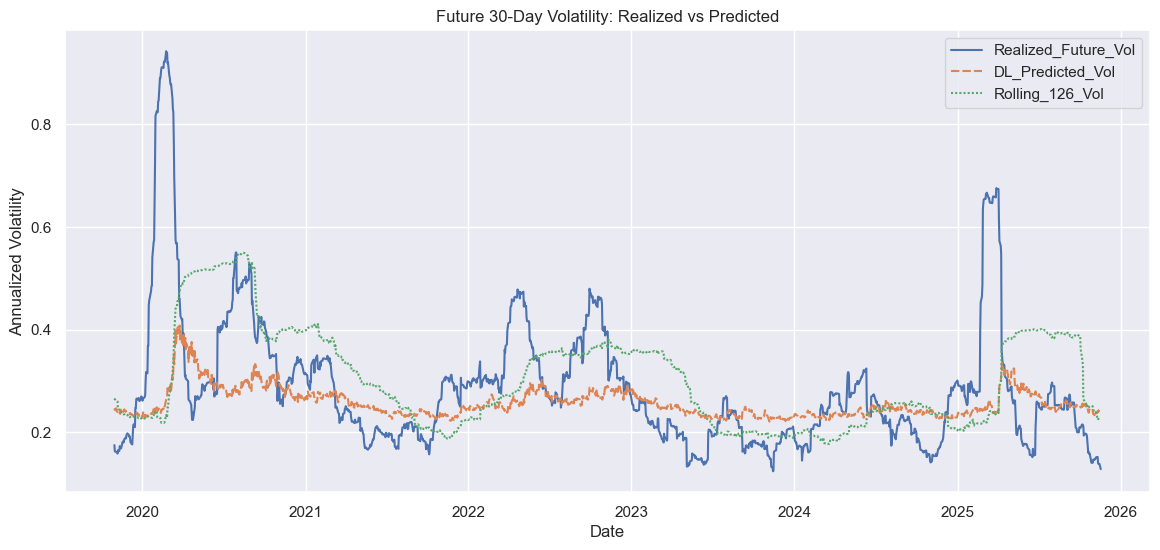

16.576013179815078 0.8050755366643112
217.22958278398661
       Iteration Number  Day       Price
0                     0    0  212.440033
1                     0    1  225.519302
2                     0    2  228.968124
3                     0    3  232.967178
4                     0    4  233.960739
...                 ...  ...         ...
38095               299  122  211.995224
38096               299  123  205.799408
38097               299  124  212.707367
38098               299  125  219.524109
38099               299  126  225.165619

[38100 rows x 3 columns]


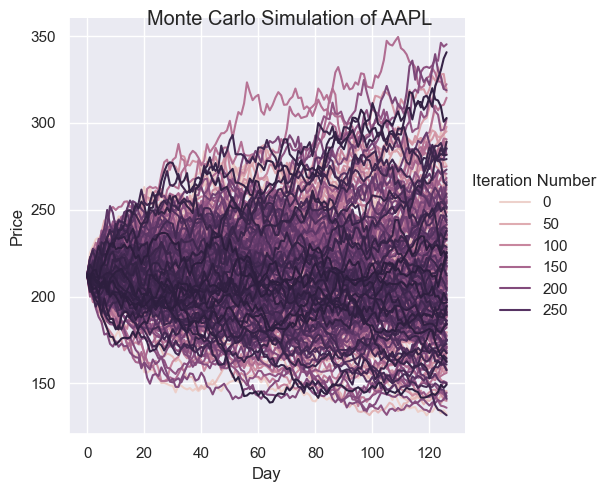

In [48]:
import torch
from torch import nn


# input: L=60 past returns, 3 rolling vols, log price -> volatility 
# (input dimention=64 -> output dimension=1)
def build_Xy(df: pd.DataFrame, L: int = 60, H: int = 30):
    """
    Build Option B features/labels:
      X_t = [r_{t-L+1}..r_t, vol20_t, vol60_t, vol126_t, logS_t]  -> shape (N, L+4)
      y_t = realized vol over next H days (annualized)            -> shape (N, 1)

    Returns:
      X_np: (N, L+4)
      y_np: (N, 1)
      df_feat: DataFrame with aligned columns 
    """
    df = df.copy()

    # Ensure sorted by time
    if isinstance(df.index, pd.DatetimeIndex):
        df = df.sort_index()
    elif "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
        df = df.dropna(subset=["Date"]).sort_values("Date").set_index("Date")

    # --- 1) Past-looking features ---
    # Daily log returns r_t = log(S_t / S_{t-1})
    df["log_price"] = np.log(df["Close"])
    df["log_returns_diff"] = df["log_price"].diff()

    # Rolling vols (annualized) using ONLY past returns up to t
    df["vol_20d"]  = df["log_returns_diff"].rolling(20).std(ddof=1)  * np.sqrt(252)
    df["vol_60d"]  = df["log_returns_diff"].rolling(60).std(ddof=1)  * np.sqrt(252)
    df["vol_126d"] = df["log_returns_diff"].rolling(126).std(ddof=1) * np.sqrt(252)

    # --- 2) Future-looking label ---
    # Realized vol over next H days: sqrt(252 * mean(r_{t+1..t+H}^2))
    df["realized_future_vol"] = np.sqrt(252 * df["log_returns_diff"].shift(-1).pow(2).rolling(H).mean().shift(-(H-1)))

    # Explanation of the label construction:
    # - shift(-1): start at t+1 (future)
    # - rolling(H).mean(): average over H future returns
    # - shift(-(H-1)): align the window's mean back to time t

    # --- 3) Build lagged-return columns for X ---
    # Create columns r_lag59 ... r_lag0 where r_lag0 = r_t
    for k in range(L):
        df[f"log_ret_lag{L-1-k}"] = df["log_returns_diff"].shift(k)

    feature_cols = [f"log_ret_lag{i}" for i in range(L)] + ["vol_20d", "vol_60d", "vol_126d", "log_price"]
    target_col = "realized_future_vol"

    # --- 4) Drop rows with any NaNs in features/target (this handles warm-up + end trimming) ---
    df_feat = df.dropna(subset=feature_cols + [target_col]).copy()

    X_np = df_feat[feature_cols].to_numpy(dtype=np.float32)
    y_np = df_feat[[target_col]].to_numpy(dtype=np.float32)  # (N, 1)


    return X_np, y_np, df_feat


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


class VolatilityMLP_NN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1) 
        )

    def forward(self, x):
        return self.net(x)



# training:
X_np, y_np, df_feat = build_Xy(df_daily, L=60, H=30)
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.float32).view(-1, 1)
model = VolatilityMLP_NN(input_dim=X.shape[1])

N = X.shape[0]
train_end = int(0.70 * N)
val_end   = int(0.85 * N)
X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

pred_log_sigma = model(X)
pred_sigma = torch.exp(pred_log_sigma)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()

    optimizer.zero_grad()

    pred = model(X_train)
    loss = criterion(pred, y_train)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
        print(f"Epoch {epoch}: train={loss.item():.4f}, val={val_loss.item():.4f}")

# evaluate on test data
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).cpu().numpy().squeeze()
    test_pred = model(X_test)
    test_loss = criterion(test_pred, y_test)
print("\nModel's Test RMSE (root mean squared error):", np.sqrt(test_loss.item()))


rolling126_pred = df_feat["vol_126d"].values
y_true = df_feat[['realized_future_vol']].to_numpy(dtype=np.float32).squeeze()
rolling126_mse = np.mean((rolling126_pred - y_true) ** 2)
print("Baseline (Rolling-126) Test RMSE:", np.sqrt(rolling126_mse))
improvement = (rolling126_mse - test_loss.item()) / rolling126_mse
print(f"MLP reduces out-of-sample MSE by aprox. {improvement*100:.4f}% relative to a rolling-126 volatility benchmark.")



# visualizing results:
test_start = val_end
test_dates = df_feat.index[test_start:]

plot_df = pd.DataFrame({
    "Date": test_dates,
    "DL_Predicted_Vol": y_pred_test,
    "Realized_Future_Vol": y_test.squeeze(),
    "Rolling_126_Vol": df_feat.loc[test_dates, "vol_126d"].values
}).set_index("Date")




plt.figure(figsize=(14, 6))
sns.lineplot(data=plot_df[["Realized_Future_Vol", "DL_Predicted_Vol", "Rolling_126_Vol"]])
plt.title("Future 30-Day Volatility: Realized vs Predicted")
plt.ylabel("Annualized Volatility")
plt.xlabel("Date")
plt.legend()
plt.show()


# running MC simulation with the now changing volatilities (in progress)

def make_features_from_history(
        log_prices: np.ndarray,
        L: int = 60,
        vol_windows=(20, 60, 126),
) -> np.ndarray:
    """
    log_prices: array of length >= max(L+1, max(vol_windows)+1)
               containing simulated log prices up through time t.
    Returns X_t shaped (L+4,) = [r_{t-L+1}..r_t, vol20, vol60, vol126, logS_t]
    """
    returns = np.diff(log_prices)
    last_L = returns[-L:]
    vols = []
    for w in vol_windows:
        rw = returns[-w:] 
        vols.append(np.std(rw, ddof=1) * np.sqrt(252))
    logS_t = log_prices[-1]

    X_t = np.concatenate([last_L, np.array(vols, dtype=np.float32), np.array([logS_t], dtype=np.float32)]).astype(np.float32)
    return X_t

#efficient
@torch.no_grad()
def calculate_MC_time_varying_vol(
    model: torch.nn.Module,
    S0: float,
    r: float,
    q: float,
    T: float,
    K: float,
    num_sims: int = 1000,
    steps: int = time_steps,
    L: int = 60,
    vol_windows=(20, 60, 126),
    warmup: int = 126,              # need enough history for vol126
    init_log_returns: np.ndarray = None,  # optional: seed history with real returns
    device: str = "cpu",
    option_type: str = "call",
):
    """
    Returns: price, standard_error, paths_df (optional for plotting)
    Time-varying sigma_t comes from model(features_t) each step.
    """

    model.eval()
    dt = T / steps
    disc = np.exp(-r * T)

    # We need initial history of log prices to compute features.
    # Either seed with real returns, or seed with zeros (less realistic).
    if init_log_returns is None:
        init_log_returns = np.zeros(warmup, dtype=np.float32)

    # Build initial log price history ending at log(S0)
    logS0 = np.log(S0)
    log_prices0 = np.empty(warmup + 1, dtype=np.float32)
    log_prices0[-1] = logS0
    for i in range(warmup - 1, -1, -1):
        log_prices0[i] = log_prices0[i + 1] - init_log_returns[i]


    payoffs = np.zeros(num_sims, dtype=np.float64)

    # want paths for plotting (can be big), store a few
    store_paths = min(num_sims, 300)
    stored = np.zeros((store_paths, steps + 1), dtype=np.float32)

    for n in range(num_sims):
        log_prices = log_prices0.copy()
        S = float(np.exp(log_prices[-1]))
        if n < store_paths:
            stored[n, 0] = S

        for t in range(steps):
            # Build X_t from current simulated history
            X_t = make_features_from_history(log_prices, L=L, vol_windows=vol_windows)

            x = torch.from_numpy(X_t).to(device).unsqueeze(0)  # (1, L+4)
            sigma_t = float(model(x).item())
            sigma_t = max(sigma_t, 1e-8)

            z = np.random.normal()
            # GBM
            logS_next = log_prices[-1] + (r - q - 0.5 * sigma_t**2) * dt + sigma_t * np.sqrt(dt) * z
            log_prices = np.append(log_prices, logS_next)
            S = float(np.exp(logS_next))

            if n < store_paths:
                stored[n, t + 1] = S

        # payoff at maturity
        if option_type.lower() == "call":
            payoffs[n] = max(S - K, 0.0)
        else:
            payoffs[n] = max(K - S, 0.0)

    price = disc * payoffs.mean()
    se = disc * payoffs.std(ddof=1) / np.sqrt(num_sims)

    # Optional: return a dataframe of stored paths for plotting
    paths_df = None
    if store_paths > 0:
        rows = []
        for i in range(store_paths):
            for t in range(steps + 1):
                rows.append({"Iteration Number": i, "Day": t, "Price": stored[i, t]})
        paths_df = pd.DataFrame(rows)

    return price, se, paths_df

warmup = 126
init_log_returns = df_daily["Close"].pipe(np.log).diff().dropna().values[-warmup:].astype(np.float32)

price_tv, se_tv, df_paths_tv = calculate_MC_time_varying_vol(
    model=model.to(device),
    S0=price_init,
    r=risk_free_rate,
    q=div_yield,
    T=maturity,
    K=strike,
    num_sims=1000,
    steps=time_steps,
    L=60,
    vol_windows=(20, 60, 126),
    warmup=warmup,
    init_log_returns=init_log_returns,
    device=device,
    option_type="call"
)

print(price_tv, se_tv)

MC_MLP_grid = sns.relplot(data=df_paths_tv, kind="line", x='Day', y='Price', hue='Iteration Number')
MC_MLP_grid.figure.suptitle(f"Monte Carlo Simulation of {ticker}")
print(np.mean(df_MC['Price']))
print(df_paths_tv)





Step 3: LSTM (takes in a sequence. learns from patterns)

In [54]:
print("LSTM to be implemented soon...")


LSTM to be implemented soon...


Step 4: Visualizing Results

Let's Compare the Monte Carlo Simulation using the time-varying volatility trained on MLP vs. the Monte Carlo Simulatioin using a constant volatility (the most recent volatility)


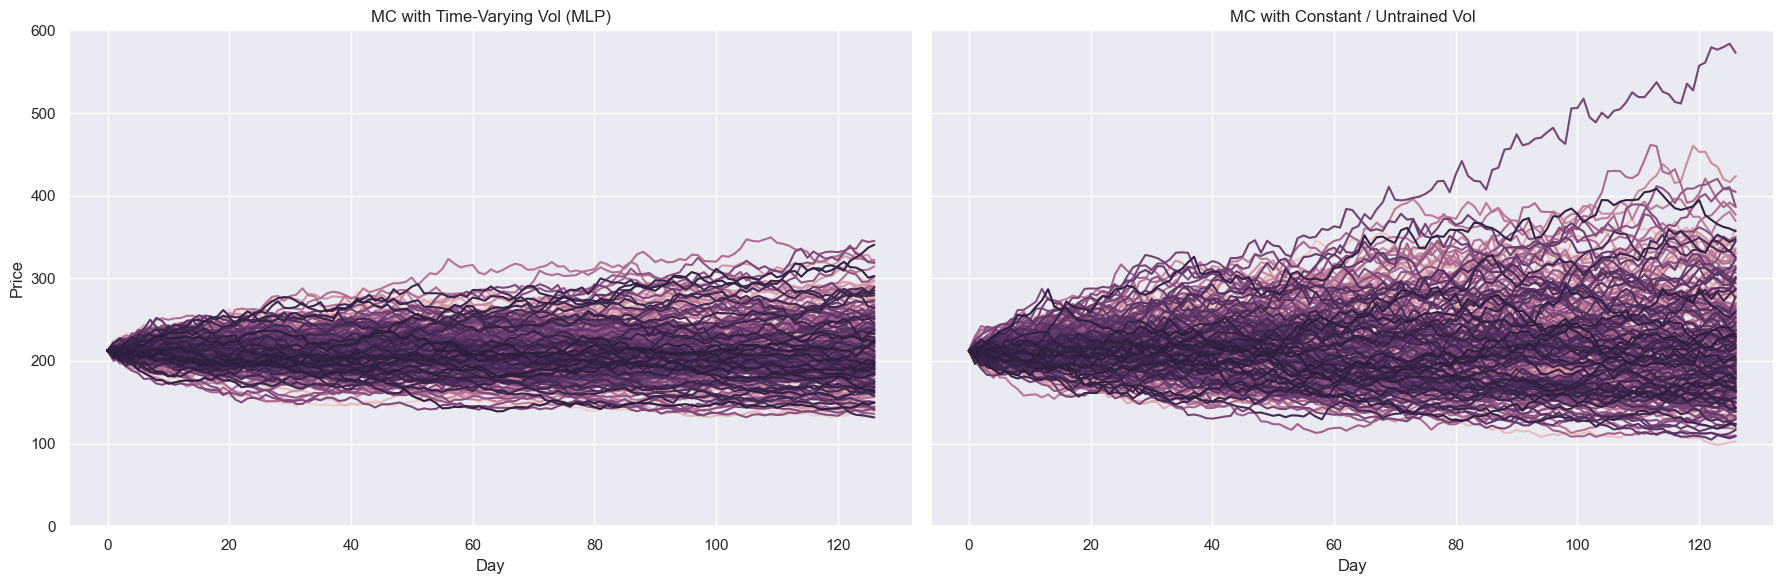

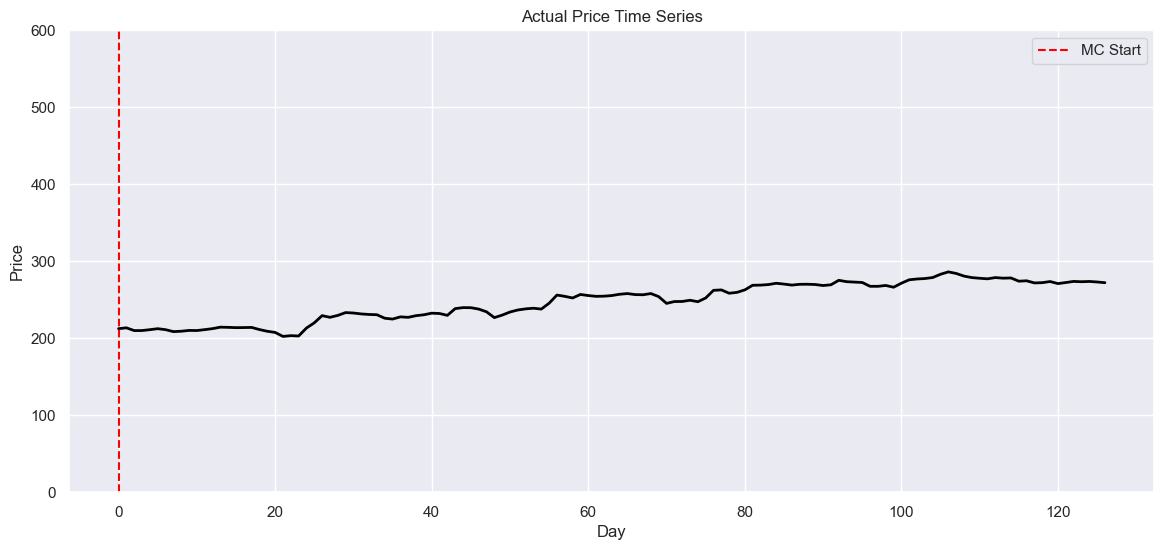

In [ ]:

print("Let's Compare the Monte Carlo Simulation using the time-varying volatility trained on MLP vs. the Monte Carlo Simulatioin using a constant volatility (the most recent volatility)")

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Left: MLP time-varying volatility
sns.lineplot(
    data=df_paths_tv,
    x="Day",
    y="Price",
    hue="Iteration Number",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("MC with Time-Varying Vol (MLP)")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Price")

# Right: baseline / untrained MC
sns.lineplot(
    data=df_MC,
    x="Day",
    y="Price",
    hue="Iteration Number",
    legend=False,
    ax=axes[1]
)
axes[1].set_title("MC with Constant / Untrained Vol")
axes[1].set_xlabel("Day")
plt.ylim(0, 600)
plt.tight_layout()
plt.show()

# Bottom: Actual Price Time-Series
mc_idx = DAYS_BEFORE_TODAY
hist_slice = df_daily.iloc[: mc_idx+1][::-1]

actual_price_df = pd.DataFrame({
    "Day": np.arange(mc_idx+1),
    "Price": hist_slice["Close"].values
})

plt.figure(figsize=(14, 6))

plt.ylim(0, 600) 
sns.lineplot(
    data=actual_price_df,
    x="Day",
    y="Price",
    linewidth=2,
    color="black"
)
plt.axvline(0, color="red", linestyle="--", label="MC Start")
plt.title("Actual Price Time Series")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.show()



Step 5: Conclusions and Findings


Overview of the Approach:

In this project, I investigated whether a data-driven, time-varying volatility model could improve upon standard rolling-window volatility estimates and produce more realistic Monte Carlo simulations for option pricing. I trained a multilayer perceptron (MLP) to forecast future realized volatility using only information available at the prediction time, and then embedded the trained model inside a Monte Carlo framework where volatility is re-predicted at every time step along each simulated price path.

The idea was to replace the constant-volatility assumption of classical geometric Brownian motion with a learned volatility process that adapts to recent returns, volatility clustering, and price level effects.


Volatility Model and Training:

The MLP was trained to predict 30-day forward realized volatility (annualized), defined as the square root of the average squared log returns over the next 30 trading days. Input features at time t consisted of:
- The past 60 daily log returns
- Three rolling historical volatility measures (20-, 60-, and 126-day windows)
- The log price level

All features were constructed using only past data, ensuring no look-ahead bias. The network architecture comprised two hidden layers with ReLU activations and was trained using mean squared error loss and the Adam optimizer. The dataset was split chronologically into training, validation, and test sets to reflect realistic forecasting conditions (70%, 15%, and 15% respectively).


Empirical Findings:

Out-of-sample evaluation showed that the MLP consistently outperformed a standard 126-day rolling volatility benchmark. On the held-out test set, the neural network achieved a lower mean squared error and root mean squared error relative to the rolling estimator, indicating that the model successfully captured nonlinear patterns in volatility dynamics that are not accessible to simple historical averages. In percentage terms, the MLP reduced test-set MSE by aproximately 49% compared to the rolling-window baseline, a significant amount.

Beyond numerical accuracy, the learned volatility forecasts exhibited regime persistence and clustering, aligning well with known empirical properties of financial volatility.


Monte Carlo Simulation Results:

The trained MLP was then integrated into a Monte Carlo simulation in which volatility is re-estimated at each time step based on the evolving simulated price history. This produced price paths that differ qualitatively from constant-volatility simulations. In contrast to the smooth, uniformly widening cones generated by standard GBM, the MLP-driven simulations displayed time-varying dispersion, reflecting periods of elevated and subdued volatility.

To ensure consistency with observed market conditions, simulations were initialized using recent historical returns (“warm-up” data), anchoring the process at the current observed price. Visual comparisons between historical prices, untrained Monte Carlo paths, and MLP-based paths confirmed that the learned-volatility model generates trajectories that more closely resemble real market behavior.


Conclusions:

Overall, this project demonstrates that machine-learned volatility models can be effectively combined with Monte Carlo methods to move beyond constant-parameter diffusion models. The MLP not only improved out-of-sample volatility forecasting performance relative to a rolling-window benchmark, but also produced more realistic, path-dependent price dynamics when embedded into simulation.

While the approach remains model-dependent and does not rely on market-implied volatility, it provides a possible flexible framework for incorporating statistical learning into risk modeling and derivative pricing. Future work could extend this framework to sequence-based architectures, volatility-of-volatility modeling, or calibration against option market data. Nonetheless, the results here suggest that learned volatility processes offer a promising and empirically grounded alternative to classical assumptions in option pricing.